In [313]:
import numpy as np
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod
from copy import deepcopy

EPSILON = 1e-8

## Optimizers

In [3]:
class BaseOptimizer(ABC):
  def __init__(self):
    self.model_params = None

  def set_learning_params(self, params: np.array):
    self.model_params = params

  @abstractmethod
  def step(self, grad: np.ndarray):
    pass

In [4]:
class ConstantLROptimizer(BaseOptimizer):
    def __init__(self, lr:float = 0.001):
        super().__init__()
        self.lr = lr

    def step(self, grad: np.ndarray):
        self.model_params -= self.lr * grad

In [5]:
class Adam(BaseOptimizer):
  def __init__(self, lr: float=0.001, beta1: float = 0.9, beta2: float = 0.999, lmbd: float=0.0, epsilon: float = 1e-8):
    super().__init__()
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.smoothing_mean = 0
    self.smoothing_std = 0
    self.t = 0
    self.beta1_t = self.beta1
    self.beta2_t = self.beta2
    self.lmbd = lmbd
    self.epsilon = epsilon

  def step(self, grad: np.ndarray):
    if self.lmbd > 0:
      grad += self.lmbd * self.model_params

    self.smoothing_mean = self.beta1 * self.smoothing_mean + \
                          (1 - self.beta1) * grad
    self.smoothing_std = self.beta2 * self.smoothing_std + \
                         (1 - self.beta2) * grad ** 2

    m_hat = self.smoothing_mean / (1 - self.beta1_t)
    v_hat = self.smoothing_std / (1 - self.beta2_t)

    self.model_params -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

    self.beta1_t *= self.beta1
    self.beta2_t *= self.beta2

In [43]:
class AdaGrad(BaseOptimizer):
  def __init__(self, lr: float=0.05, eta: float = 0.01, lmbd: float = 0.0,
               initial_accumulator_value: float = 0.0, epsilon: float = 1e-8):
    super().__init__()
    self.lr = lr
    self.eta = eta
    self.lmbd = lmbd
    self.state_sum = initial_accumulator_value
    self.epsilon = epsilon
    self.t = 0

  def step(self, grad: np.ndarray):
    if self.lmbd > 0:
      grad += self.lmbd * self.model_params

    lr = self.lr / (1 + self.t * self.eta)

    self.state_sum += grad ** 2

    self.model_params -= lr * grad / (np.sqrt(self.state_sum) + self.epsilon)

    self.t += 1

## Gradient descent

In [348]:
class LossFunction(ABC):
  @abstractmethod
  def compute(self, y_predicted, y_target):
    pass

  @abstractmethod
  def compute_grad(self, y_predicted, y_target):
    pass



class MSE(LossFunction):
  def compute(self, y_predicted, y_target):
    error = (y_predicted - y_target)
    return np.mean((y_predicted - y_target) ** 2)

  def compute_grad(self, y_predicted, y_target):
    return 2 / len(y_target) * (y_predicted - y_target)



class CrossEntropyLoss(LossFunction):
  def compute(self, y_predicted, y_target):
    # print(y_target, y_predicted)
    return - np.mean(y_target * np.log(y_predicted + EPSILON) + \
                     (1 - y_target) * np.log(1 + EPSILON - y_predicted))
    # return (y_predicted[y_target.astype(int)]).mean()

  def compute_grad(self, y_predicted, y_target):
    return (y_predicted - y_target) / (y_predicted * (1 - y_predicted) * len(y_target) + EPSILON)

# Linear Regression

## Model

$$
    p(y| X, w) = Xw
$$

## Loss

$$
Loss(X, y, w)= \frac{1}{n}\|y-Xw\|^2_2= \frac{1}{n} (y - Xw)^T (y - Xw)= \frac{2}{n} \left[y^ty - 2 y^tXw + w^tX^TXw \right]
$$

## Gradient
$$
\nabla_w l = \frac{1}{n} (-2X^Ty + 2X^TXw) = \frac{2}{n}X^T (Xw-y)
$$

In [349]:
class Model(ABC):
  def __init__(self):
    self.weights = None

  @abstractmethod
  def prepare_data(self, X: np.ndarray):
    pass

  @abstractmethod
  def compute_grad(self, X: np.ndarray, input_value: np.ndarray, input_grad: np.ndarray):
    pass

  @abstractmethod
  def apply(self, X: np.ndarray):
    pass

  def predict(self, X: np.ndarray):
    X = self.prepare_data(X)
    return self.apply(X)

In [350]:
class CustomLinearRegression(Model):
  def __init__(self, num_features: int):
    self.weights = np.random.normal(0, 1 / np.sqrt(num_features + 1), num_features + 1)

  def prepare_data(self, X: np.ndarray):
    return np.concatenate([X, np.ones((X.shape[0], 1))], axis=-1)

  def compute_grad(self, X: np.ndarray, input_value: np.ndarray, input_grad: np.ndarray):
    batch_size = X.shape[0]
    return X.T @ input_grad

  def apply(self, X: np.ndarray):
    return X @ self.weights

# Logistic Regression for binary classification

## Model

$$
    p(y = 1| X, w) = \sigma(w^T X) = \frac{1}{1 + e^{-Xw}}
$$

## Loss
$$
Loss(X, y, w) = \sum_{i=1}^N y_i \log \left( \sigma(Xw)\right) + (1 - y_i) \log \left( 1 - \sigma(Xw)\right)
$$

## Gradient
$$
\nabla_w Loss(X, y, w) = -\sum_{i=1}^N x_i^T(y_i - \sigma(x_i^Tw)) = X^T(\sigma(Xw) - y)
$$

In [351]:
class LogisticRegressionBC(Model):
  def __init__(self, num_features: int):
    self.weights = np.random.rand(num_features + 1)

  def prepare_data(self, X: np.ndarray):
    return np.concatenate([X, np.ones((X.shape[0], 1))], axis=-1)

  def _sigmoid(self, x: np.ndarray):
    return 1 / (1 + np.exp(-x))

  def compute_grad(self, X: np.ndarray, input_value: np.ndarray, input_grad: np.ndarray):
    dpred_dxw = input_value * (1 - input_value)
    return X.T @ (dpred_dxw * input_grad)

  def apply(self, X: np.ndarray):
    return self._sigmoid(X @ self.weights)


# Stochastic gradient descent

In [352]:
def SGD(X: np.ndarray, y: np.ndarray, model: Model, loss_function = MSE(),
        opt:BaseOptimizer=ConstantLROptimizer(1e-3), batch_size:int=None,
        n_epochs:int=100):
  X_prepared = model.prepare_data(X)
  y_prepared = deepcopy(y)
  n = len(y)

  loss_history = []

  if batch_size is None:
    batch_size = n

  for _ in range(n_epochs):
    shuffle_ids = np.arange(n)
    if batch_size != n:
      np.random.shuffle(shuffle_ids)
    X_prepared, y_prepared = X_prepared[shuffle_ids], y_prepared[shuffle_ids]

    for start_id in range(0, n, batch_size):
      X_batch = X_prepared[start_id : start_id + batch_size]
      y_batch = y_prepared[start_id : start_id + batch_size]

      y_predict = model.apply(X_batch)
      loss = loss_function.compute(y_predict, y_batch)
      loss_grad = loss_function.compute_grad(y_predict, y_batch)
      grad = model.compute_grad(X_batch, y_predict, loss_grad)

      opt.step(grad)

      loss_history.append(loss)

  return loss_history

# Simple Test

In [353]:
k = 5
theta = np.random.rand(k + 1)

X_train = np.random.rand(100, k)

y_train = np.concatenate([X_train, np.ones((100, 1))], -1) @ theta
theta

array([0.6966931 , 0.11551982, 0.25262166, 0.52246133, 0.09366797,
       0.33004939])

In [354]:
opts = {
        "ConstantLROptimizer" : ConstantLROptimizer(1e-3),
        "Adam": Adam(),
        "AdaGrad": AdaGrad()
}

Optimizer ConstantLROptimizer : diff = 0.16173651717002627
Optimizer Adam : diff = 0.09465481624794247
Optimizer AdaGrad : diff = 0.007988808435046577


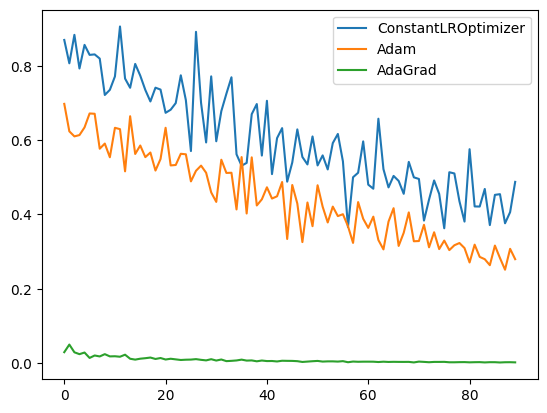

In [355]:
mse_loss = MSE()
loss_hist = dict()
preds_hist = dict()

for name, opt in opts.items():
  lm = CustomLinearRegression(k)
  opt.set_learning_params(lm.weights)

  loss_hist[name] = SGD(X_train, y_train, lm, mse_loss, opt, n_epochs=30,
                        batch_size=40
                        )


  print(f"Optimizer {name} : diff = {mse_loss.compute(lm.weights, theta)}")

  plt.plot(loss_hist[name], label=name)

plt.legend()
plt.show()

In [408]:
from scipy.special import expit

k = 3
theta = np.random.rand(k + 1)

X_train = np.random.normal(0, 1, (100, k))

y_train = expit(np.concatenate([X_train, np.ones((100, 1))], -1) @ theta + np.random.normal(0, 1e-1, 100)) > 0.5
theta

array([0.02566502, 0.1718051 , 0.8062423 , 0.37121777])

In [409]:
opts = {
        "ConstantLROptimizer" : ConstantLROptimizer(1e-3),
        "Adam": Adam(),
        "AdaGrad": AdaGrad()
}

Optimizer ConstantLROptimizer : accuracy = 0.57 diff = 0.21428806172578393
Optimizer Adam : accuracy = 0.8 diff = 0.20390191910330327
Optimizer AdaGrad : accuracy = 0.68 diff = 0.33869586701933774


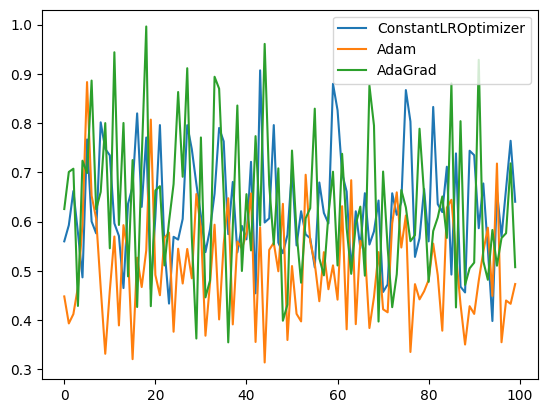

In [411]:
ce_loss = CrossEntropyLoss()
loss_hist = dict()
preds_hist = dict()

for name, opt in opts.items():
  lm = LogisticRegressionBC(k)
  opt.set_learning_params(lm.weights)

  loss_hist[name] = SGD(X_train, y_train, lm, ce_loss, opt, n_epochs=10,
                        batch_size=10
                        )

  preds = lm.predict(X_train) > 0.5
  print(f"Optimizer {name} : accuracy = {np.mean(preds == y_train)} diff = {mse_loss.compute(lm.weights, theta)}")

  plt.plot(loss_hist[name], label=name)

plt.legend()
plt.show()

# On real data Linear regression

In [461]:
import pandas as pd

data = pd.read_csv("Real estate.csv", index_col=0)
data.head(3)

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
No,,,,,,,
1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3


In [462]:
target_col = "Y house price of unit area"

y = data[target_col].to_numpy()
X = data.drop(columns=[target_col]).to_numpy()

X.shape, y.shape

((414, 6), (414,))

In [463]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_offset = y_train.mean()
y_train -= y_offset
y_test -= y_offset

len(y_train), len(y_test), scaler.mean_, scaler.scale_

(372,
 42,
 array([2013.15212903,   17.5188172 , 1069.69239634,    4.13172043,
          24.96924366,  121.53380366]),
 array([2.82293143e-01, 1.12429223e+01, 1.23677869e+03, 2.94416942e+00,
        1.23829361e-02, 1.51756251e-02]))

In [464]:
mse = MSE()

In [465]:
lm = LinearRegression(fit_intercept=False)

lm.fit(X_train, y_train)

base_preds = lm.predict(X_test)

base_mse_score = mse.compute(base_preds, y_test)
base_r2_score = r2_score(y_test, base_preds)
print(f"Sklearn model mse = {base_mse_score}, r2_score = {base_r2_score}")

Sklearn model mse = 70.71754264354217, r2_score = 0.6391741279713876


My model mse = 63.74847922946663, r2 = 0.6391741279713876


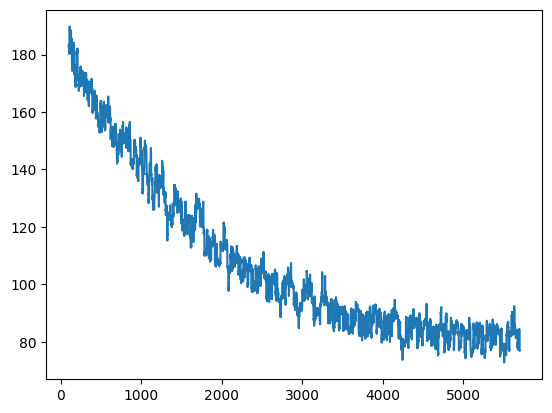

In [470]:
my_lm = CustomLinearRegression(6)

opt = Adam()
opt.set_learning_params(my_lm.weights)

loss_history = SGD(X_train, y_train, my_lm, mse, opt=opt,
                   batch_size=10,
                   n_epochs=150)


my_preds = my_lm.predict(X_test)
base_mse_score = mse.compute(my_preds, y_test)
base_r2_score = r2_score(y_test, base_preds)

print(f"My model mse = {base_mse_score}, r2 = {base_r2_score}")

smoothed_loss_history = [np.mean(loss_history[step - 100: step]) for step in range(len(loss_history))]
plt.plot(smoothed_loss_history)
plt.show()

# On real data Logistic Rergession

In [449]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve

In [453]:
def plot_roc_curve(y_target, y_pred_prob):
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
  plt.figure()
  plt.plot(fpr, tpr)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve for Breast Cancer Classification')
  plt.legend()
  plt.show()

In [448]:
X, y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                      test_size=0.20,
                                      random_state=23)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

((455, 30), (114, 30))

In [446]:
clf = LogisticRegression(fit_intercept=False)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Sklearn Logistic Regression model accuracy = {acc * 100}%")

Sklearn Logistic Regression model accuracy = 98.24561403508771%


My Logistic Regression model accuracy = 96.49122807017544%


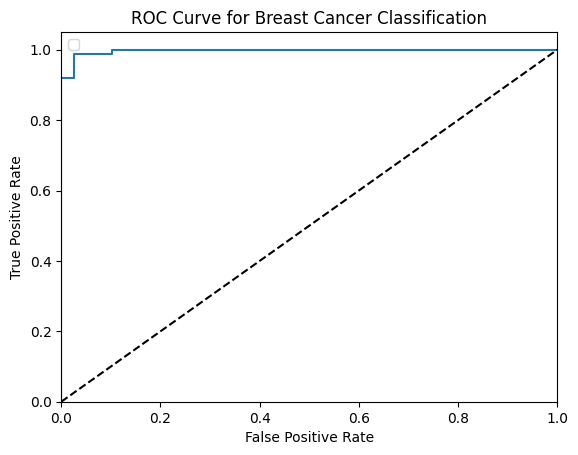

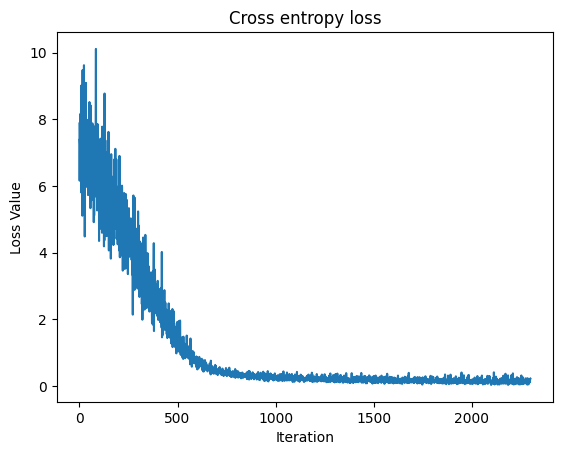

In [ ]:
my_clf = LogisticRegressionBC(30)

opt = Adam()
ce_loss = CrossEntropyLoss()

opt.set_learning_params(my_clf.weights)

loss_history = SGD(X_train, y_train, my_clf, ce_loss, opt=opt,
                      batch_size=20,
                      n_epochs=100
                  )


probas = my_clf.predict(X_test)
my_preds = probas > 0.5
accuracy = accuracy_score(y_test, my_preds)

print(f"My Logistic Regression model accuracy = {accuracy * 100}%")

plot_roc_curve(y_test, probas)

plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss Value")
plt.title("Cross entropy loss")
plt.show()